# Extracting Data from the EPA's AirNow API
You must first obtain an API key. Go to https://docs.airnowapi.org/login and request an API key.

In [1]:
from datetime import datetime, timedelta
import os
os.chdir('../')

import contextily as ctx
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from src.config import EPA_KEY

In [2]:
# set a latitude and longitude point as a center of interest
LATLON = [41.830717,-87.6778327] # random point in McKinley Park, Chicago, IL

# determine a radius for all air quality sensors
DISTANCE= 25

# set date of interest for AQI data 
TODAY = datetime.today()
START_DATE = (TODAY - timedelta(days=14)).strftime('%Y-%m-%d') # start date is 2 weeks ago
END_DATE = TODAY.strftime('%Y-%m-%d') # end date is today

# define parameters of interest
PARAMS_RAW = ['OZONE','PM25']
PARAMS = ''.join([s+',' if s != PARAMS_RAW[-1] else s for s in PARAMS_RAW])

# define bounding box for sensor data
BBOX=[-87.912584,41.587576,-87.522570,42.109292] # cook county - more or less
BBOX_x=''.join([str(s)+',' if s != BBOX[-1] else str(s) for s in BBOX])

## Reporting Site Readings
Reporting sites are large areas where sensor data has been averaged to produce a reported air quality measure. This is often what is used to create AQI safety warnings. We want to compare these readings with localized data to see if areas with poor air quality are being overlooked as they are averaged out with other sensors.

In [3]:
# This query will return a reading from any reporting sites
rs_query = (
    f"https://www.airnowapi.org/aq/observation/latLong/current/" \
    f"?format=text/csv&latitude={str(LATLON[0])}&longitude={LATLON[1]}" \
    f"&date={START_DATE}&distance={str(DISTANCE)}&API_KEY={EPA_KEY}"
)

report_site_df = pd.read_csv(rs_query)

In [4]:
report_site_df

,DateObserved,HourObserved,LocalTimeZone,ReportingArea,StateCode,Latitude,Longitude,ParameterName,AQI,CategoryNumber,CategoryName
0,2021-09-08,21,CST,Chicago,IL,41.964,-87.659,O3,31,1,Good
1,2021-09-08,21,CST,Chicago,IL,41.964,-87.659,PM2.5,30,1,Good


## Individual Sensor Readings
Individual sensors provide a more localized view of air quality, but we will want to compare with even more localized data to see if it is enough.

In [5]:
# this query will pull all readings within a specified date range and bounding box
is_query=(
    f"https://www.airnowapi.org/aq/data/?startDate={START_DATE}T02&endDate={END_DATE}" \
    f"T03&parameters={PARAMS}&BBOX={BBOX_x}&dataType=B&format=text/csv" \
    f"&verbose=0&nowcastonly=0&includerawconcentrations=0&API_KEY={EPA_KEY}"
)

# pull data into dataframe
indiv_sensor_df=pd.read_csv(
    is_query, 
    names=['Latitude','Longitude','DateTime','Parameter','Concentration','Unit','AQI','Category'],
    parse_dates = ['DateTime']
)

# create a column that can be used to average readings by day
indiv_sensor_df['Day'] = indiv_sensor_df.DateTime.dt.strftime('%b %d')

In [6]:
indiv_sensor_df.head()

,Latitude,Longitude,DateTime,Parameter,Concentration,Unit,AQI,Category,Day
0,41.965000,-87.876100,2021-08-25 02:00:00,OZONE,24.0,PPB,22,1,Aug 25
1,42.060300,-87.863100,2021-08-25 02:00:00,OZONE,34.0,PPB,31,1,Aug 25
2,42.060300,-87.863100,2021-08-25 02:00:00,PM2.5,0.8,UG/M3,3,1,Aug 25
3,41.984402,-87.791901,2021-08-25 02:00:00,OZONE,34.0,PPB,31,1,Aug 25
4,41.855301,-87.752502,2021-08-25 02:00:00,OZONE,34.0,PPB,31,1,Aug 25


In [7]:
# see how many readings there are at a given location by parameter
indiv_sensor_df.groupby(['Latitude','Longitude','Parameter']).size()

Latitude   Longitude   Parameter
41.670800  -87.732500  OZONE        338
                       PM2.5        338
41.754700  -87.713600  OZONE        338
                       PM2.5        336
41.755798  -87.545303  OZONE        338
41.855301  -87.752502  OZONE        338
41.864329  -87.748826  PM2.5        336
41.913600  -87.723900  PM2.5        338
41.965000  -87.876100  OZONE        338
41.984402  -87.791901  OZONE        338
42.060300  -87.863100  OZONE        338
                       PM2.5        338
42.062200  -87.673600  OZONE        338
dtype: int64

In [8]:
monitors = indiv_sensor_df[['Latitude','Longitude']].drop_duplicates()

# convert monitor locations to geodataframe
gdf = gpd.GeoDataFrame(
    monitors,
    crs='EPSG:4326',
    geometry=gpd.points_from_xy(monitors.Longitude, monitors.Latitude), 
).to_crs('EPSG:3857')

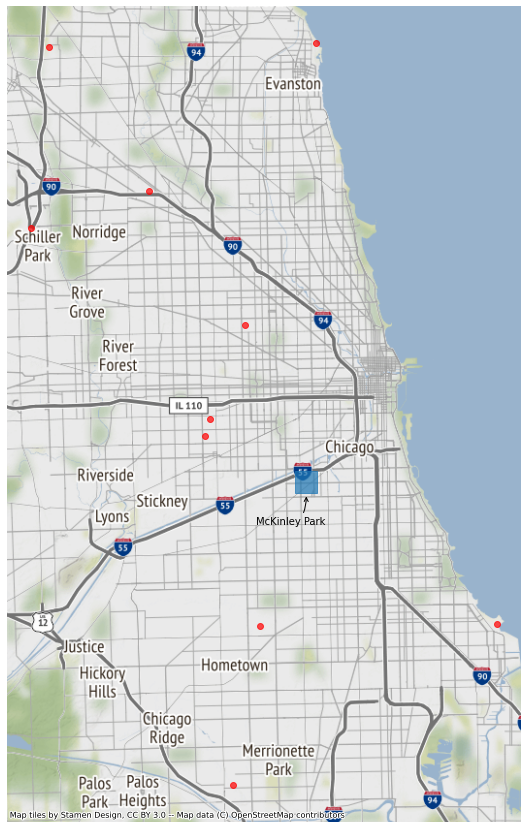

In [9]:
# create point for approx center of McKinley Park
mck_park = Point(-87.6805366, 41.8310785)
gdf_mck = gpd.GeoSeries([mck_park], crs='EPSG:4326')
gdf_mck = gdf_mck.to_crs('EPSG:3857') # convert CRS projection


# create map of sensors
ax = gdf.plot(
    figsize=(10, 15), 
    alpha=0.7, 
    color='red'
)

# plot McKinley Park area
gdf_mck.plot(
    ax=ax, 
    alpha=0.7,
    marker='s',
    markersize=500
)

# label McKinley Park
an2 = ax.annotate(
    "McKinley Park", xy=(gdf_mck.geometry.x[0], gdf_mck.geometry.y[0]-1000),
    textcoords="offset points",xytext=(-50,-30), 
    arrowprops=dict(arrowstyle="->", connectionstyle="angle3,angleA=0,angleB=90")
)

# add background map
ctx.add_basemap(ax)

ax.set_axis_off()